In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb, to_rgb
import pandas as pd
import seaborn as sns
import scipy
from teeplot import teeplot as tp

import random


In [2]:
# adapted from https://stackoverflow.com/a/78998203/17332200
def darken(color, amount):
    hue, saturation, value = rgb_to_hsv(to_rgb(color))
    return hsv_to_rgb((hue, saturation, value * amount))


In [3]:
def darken_palette(palette: str, amount: float) -> list:
    palette = sns.color_palette(palette)
    return [darken(color, amount) for color in palette]


In [4]:
# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)


## Get Data


In [5]:
df = pd.read_parquet("https://osf.io/gk2ty/download")


In [6]:
df.columns


Index(['Task', 'Treatment', 'Genome Length', 'Lineage Generation Index',
       'Run ID', 'Is Task Coding Site', 'Is Viability Site',
       'Is Task Coding Site Cumulative Count',
       'Is Viability Site Cumulative Count',
       'Prev Is Task Coding Site Cumulative Count',
       'Prev Is Viability Site Cumulative Count', 'Prev Is Task Coding Site',
       'Prev Is Viability Site', 'Site', 'Has Task', 'has task',
       'delta has task', 'Delta Has Task', 'CHILD_SOURCE_MAP',
       'POINT_MUTATION_BOOL_MASK', 'SLIP_INSERTION_ORIGIN_BOOL_MASK',
       'SLIP_INSERTION_RESULT_BOOL_MASK', 'GENOME_CHARACTERS',
       'Is Task Coding Site Delta', 'Is Viability Site Delta',
       'Point Mutation Cumulative Count', 'Slip Insertion Cumulative Count',
       'Prev Slip Insertion Cumulative Count', 'SLIP_INSERTION_BOOL_MASK',
       'Generation Born', 'Update Born'],
      dtype='object')

## Prep Data


In [7]:
df["Components"] = df["Task"].map(
    {
        "AND": 2,
        "ANDNOT": 3,
        "NAND": 1,
        "NOR": 4,
        "NOT": 1,
        "OR": 3,
        "ORNOT": 2,
        "XOR": 4,
        "EQUALS": 5,
    },
)


In [8]:
df["codes for num tasks"] = df.groupby(
    ["Site", "Lineage Generation Index", "Treatment", "Run ID"],
    observed=True,
)["Is Task Coding Site"].transform("sum")


In [9]:
df["prev codes for num tasks"] = df.groupby(
    ["Site", "Lineage Generation Index", "Treatment", "Run ID"],
    observed=True,
)["Prev Is Task Coding Site"].transform("sum")


In [10]:
df["prev codes for tasks"] = df["prev codes for num tasks"].astype(bool)


In [11]:
df["prev coded for tasks"] = df.groupby(
    ["Site", "Lineage Generation Index", "Treatment", "Run ID"],
    observed=True,
)["Prev Is Task Coding Site Cumulative Count"].transform("sum")
df["prev coded for tasks"] = df["prev coded for tasks"].astype(bool)


In [12]:
df['First Task Generation'] = df['Generation Born'].where(
    df['has task'] != 0,
).groupby(
    [df['Treatment'], df['Run ID'], df['Task']],
    observed=True,
).transform('min')


In [13]:
df["SLIP_INSERTION_BOOL_MASK any"] = df.groupby(
    ["Lineage Generation Index", "Treatment", "Run ID"],
    observed=True,
)["SLIP_INSERTION_BOOL_MASK"].transform("any")


In [14]:
dff = df[
    (df["delta has task"] == 1)
    & (df["Generation Born"] == df["First Task Generation"])
    & (df["Treatment"] == "Slip-duplicate")
    # & df["Is Task Coding Site"]
].reset_index(drop=True)
dff


,Task,Treatment,Genome Length,Lineage Generation Index,Run ID,Is Task Coding Site,Is Viability Site,Is Task Coding Site Cumulative Count,Is Viability Site Cumulative Count,Prev Is Task Coding Site Cumulative Count,...,SLIP_INSERTION_BOOL_MASK,Generation Born,Update Born,Components,codes for num tasks,prev codes for num tasks,prev codes for tasks,prev coded for tasks,First Task Generation,SLIP_INSERTION_BOOL_MASK any
0,AND,Slip-duplicate,430,47,run_1590,False,True,0,48,0,...,False,260,4010,2,0,0,False,False,260.0,True
1,AND,Slip-duplicate,430,47,run_1590,False,True,0,48,0,...,False,260,4010,2,0,0,False,False,260.0,True
2,AND,Slip-duplicate,430,47,run_1590,False,True,0,48,0,...,False,260,4010,2,0,0,False,False,260.0,True
3,AND,Slip-duplicate,430,47,run_1590,False,True,0,48,0,...,False,260,4010,2,0,0,False,False,260.0,True
4,AND,Slip-duplicate,430,47,run_1590,False,True,0,48,0,...,False,260,4010,2,0,0,False,False,260.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81054,XOR,Slip-duplicate,403,98,run_1619,False,True,0,40,0,...,False,623,8616,4,0,0,False,False,623.0,False
81055,XOR,Slip-duplicate,403,98,run_1619,False,True,0,40,0,...,False,623,8616,4,0,0,False,False,623.0,False
81056,XOR,Slip-duplicate,403,98,run_1619,False,True,0,40,0,...,False,623,8616,4,0,0,False,False,623.0,False
81057,XOR,Slip-duplicate,403,98,run_1619,False,True,0,40,0,...,False,623,8616,4,0,0,False,False,623.0,False


In [15]:
dff.columns


Index(['Task', 'Treatment', 'Genome Length', 'Lineage Generation Index',
       'Run ID', 'Is Task Coding Site', 'Is Viability Site',
       'Is Task Coding Site Cumulative Count',
       'Is Viability Site Cumulative Count',
       'Prev Is Task Coding Site Cumulative Count',
       'Prev Is Viability Site Cumulative Count', 'Prev Is Task Coding Site',
       'Prev Is Viability Site', 'Site', 'Has Task', 'has task',
       'delta has task', 'Delta Has Task', 'CHILD_SOURCE_MAP',
       'POINT_MUTATION_BOOL_MASK', 'SLIP_INSERTION_ORIGIN_BOOL_MASK',
       'SLIP_INSERTION_RESULT_BOOL_MASK', 'GENOME_CHARACTERS',
       'Is Task Coding Site Delta', 'Is Viability Site Delta',
       'Point Mutation Cumulative Count', 'Slip Insertion Cumulative Count',
       'Prev Slip Insertion Cumulative Count', 'SLIP_INSERTION_BOOL_MASK',
       'Generation Born', 'Update Born', 'Components', 'codes for num tasks',
       'prev codes for num tasks', 'prev codes for tasks',
       'prev coded for tasks', 

In [16]:
dfy = dff.groupby(
    ["Treatment", "Run ID", "Task"],
    observed=True,
)["Is Task Coding Site"].transform("mean")
print(dfy)

dff["Mean Is Task Coding Site"] = dfy


0        0.048837
1        0.048837
2        0.048837
3        0.048837
4        0.048837
           ...   
81054    0.014888
81055    0.014888
81056    0.014888
81057    0.014888
81058    0.014888
Name: Is Task Coding Site, Length: 81059, dtype: float64


In [17]:
dfp = dff.astype(
    {"Prev Slip Insertion Cumulative Count": bool},
).groupby(
    ["Treatment", "Run ID", "Task", "Prev Slip Insertion Cumulative Count"],
    observed=True,
).agg(
    {
        "Mean Is Task Coding Site": "first",
        "Is Task Coding Site": "mean",
        "Components": "first",
        "SLIP_INSERTION_BOOL_MASK any": "first",
    },
)

dfp["Is Task Coding Site"] /= dfp["Mean Is Task Coding Site"]
dfp = dfp.reset_index()
dfp


,Treatment,Run ID,Task,Prev Slip Insertion Cumulative Count,Mean Is Task Coding Site,Is Task Coding Site,Components,SLIP_INSERTION_BOOL_MASK any
0,Slip-duplicate,run_1590,AND,False,0.048837,1.890110,2,True
1,Slip-duplicate,run_1590,AND,True,0.048837,0.261398,2,True
2,Slip-duplicate,run_1590,ANDNOT,False,0.070234,0.000000,3,False
3,Slip-duplicate,run_1590,ANDNOT,True,0.070234,2.047945,3,False
4,Slip-duplicate,run_1590,EQUALS,False,0.074534,1.585606,5,False
...,...,...,...,...,...,...,...,...
482,Slip-duplicate,run_1619,OR,True,0.119497,1.296516,3,False
483,Slip-duplicate,run_1619,ORNOT,False,0.012579,0.903409,2,False
484,Slip-duplicate,run_1619,ORNOT,True,0.012579,1.119718,2,False
485,Slip-duplicate,run_1619,XOR,False,0.014888,0.000000,4,False


## `slipgain=only`


In [18]:
dfp_ = dfp.copy()
dfp_["Prev Slip Insertion Cumulative Count"] = dfp_[
    "Prev Slip Insertion Cumulative Count"
].map(
    {True: "Slip Inserted", False: "Not Slip Inserted"}
)
data = dfp_[
    dfp_["SLIP_INSERTION_BOOL_MASK any"]
    & (dfp_["Prev Slip Insertion Cumulative Count"] == "Slip Inserted")
].groupby(
    ["Prev Slip Insertion Cumulative Count", "Run ID", "Is Task Coding Site", "Components"],
    observed=True,
).median(numeric_only=True).reset_index()


In [19]:
# Perform one-sample Wilcoxon signed-rank test for each "Components" group
# against the null hypothesis median = 1.0
wilcoxon_results = data.groupby("Components").apply(
    lambda x: scipy.stats.wilcoxon(
        x["Is Task Coding Site"] - 1.0,  # shift by 1.0
        alternative='greater',
    )
)

# Create a DataFrame to store the test results
wilcoxon_df = pd.DataFrame(
    wilcoxon_results.tolist(),
    index=wilcoxon_results.index,
    columns=["W-statistic", "p-value"]
)

display(wilcoxon_df)

group_stats = data.groupby(["Components", "Prev Slip Insertion Cumulative Count"])["Is Task Coding Site"].agg(["mean", "std"]).reset_index()
display(group_stats)

group_sizes = data.groupby(["Components", "Prev Slip Insertion Cumulative Count"]).size().reset_index(name='size')
display(group_sizes)


/tmp/ipykernel_4025/1046056488.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wilcoxon_results = data.groupby("Components").apply(


,W-statistic,p-value
Components,,
1,101.0,0.799585
2,156.0,0.079455
3,92.0,0.005371
4,118.0,0.078379
5,32.0,0.027344


,Components,Prev Slip Insertion Cumulative Count,mean,std
0,1,Slip Inserted,0.974147,1.239038
1,2,Slip Inserted,1.594375,1.407244
2,3,Slip Inserted,1.878800,1.110595
3,4,Slip Inserted,1.126660,0.594308
4,5,Slip Inserted,1.357272,0.358661


,Components,Prev Slip Insertion Cumulative Count,size
0,1,Slip Inserted,22
1,2,Slip Inserted,21
2,3,Slip Inserted,14
3,4,Slip Inserted,18
4,5,Slip Inserted,8


/tmp/ipykernel_4025/4264569817.py:16: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_4025/4264569817.py:31: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  sns.stripplot(


teeplots/density-norm=width+hue=components+slipgain=only+viz=violinplot+x=components+y=is-task-coding-site+ext=.pdf


teeplots/density-norm=width+hue=components+slipgain=only+viz=violinplot+x=components+y=is-task-coding-site+ext=.png


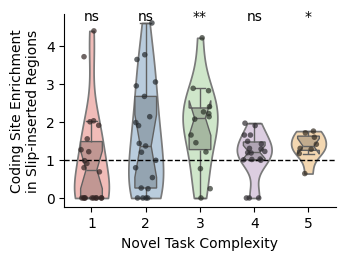

In [20]:
with tp.teed(
    sns.violinplot,
    data=data,
    y="Is Task Coding Site",
    x="Components",
    hue="Components",
    density_norm="width",
    cut=0,
    gap=0.2,
    inner=None,
    legend=False,
    palette="Pastel1",
    teeplot_outattrs={"slipgain": "only"},
    teeplot_outexclude="palette",
) as ax:
    sns.boxplot(
        data=data,
        y="Is Task Coding Site",
        x="Components",
        hue="Components",
        gap=0.2,
        notch=True,
        palette=darken_palette("Pastel1", 0.8),
        color="black",
        width=0.5,
        linewidth=1,
        fliersize=0,
        ax=ax,
        legend=False,
    )
    sns.stripplot(
        data=data,
        y="Is Task Coding Site",
        x="Components",
        hue="Components",
        jitter=0.2,
        palette=darken_palette("Pastel1", 0.2),
        size=4,
        alpha=0.7,
        ax=ax,
        legend=False,
    )
    ax.axhline(1, color="black", linestyle="--", lw=1)
    ax.set_ylabel("Coding Site Enrichment\nin Slip-inserted Regions")
    ax.set_xlabel("Novel Task Complexity")
    ax.figure.set_size_inches(3.5, 2.5)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Add significance annotations based on wilcoxon_df
    y_max = ax.get_ylim()[1]
    x_positions = ax.get_xticks()

    # Loop over each component in sorted order
    for i, comp in enumerate(sorted(wilcoxon_df.index)):
        p_val = wilcoxon_df.loc[comp, 'p-value']
        if p_val < 0.001:
            sig = '***'
        elif p_val < 0.01:
            sig = '**'
        elif p_val < 0.05:
            sig = '*'
        else:
            sig = 'ns'
        ax.text(x_positions[i], y_max * 0.95, sig, ha='center', va='bottom', fontsize=10, color='black')


## base


In [21]:
dfp_ = dfp.copy()
dfp_["Prev Slip Insertion Cumulative Count"] = dfp_[
    "Prev Slip Insertion Cumulative Count"
].map(
    {True: "Slip Inserted", False: "Not Slip Inserted"}
)
dfp_


,Treatment,Run ID,Task,Prev Slip Insertion Cumulative Count,Mean Is Task Coding Site,Is Task Coding Site,Components,SLIP_INSERTION_BOOL_MASK any
0,Slip-duplicate,run_1590,AND,Not Slip Inserted,0.048837,1.890110,2,True
1,Slip-duplicate,run_1590,AND,Slip Inserted,0.048837,0.261398,2,True
2,Slip-duplicate,run_1590,ANDNOT,Not Slip Inserted,0.070234,0.000000,3,False
3,Slip-duplicate,run_1590,ANDNOT,Slip Inserted,0.070234,2.047945,3,False
4,Slip-duplicate,run_1590,EQUALS,Not Slip Inserted,0.074534,1.585606,5,False
...,...,...,...,...,...,...,...,...
482,Slip-duplicate,run_1619,OR,Slip Inserted,0.119497,1.296516,3,False
483,Slip-duplicate,run_1619,ORNOT,Not Slip Inserted,0.012579,0.903409,2,False
484,Slip-duplicate,run_1619,ORNOT,Slip Inserted,0.012579,1.119718,2,False
485,Slip-duplicate,run_1619,XOR,Not Slip Inserted,0.014888,0.000000,4,False


In [22]:
data = dfp_[
    (dfp_["Prev Slip Insertion Cumulative Count"] == "Slip Inserted")
].groupby(
    ["Prev Slip Insertion Cumulative Count", "Run ID", "Is Task Coding Site", "Components"],
    observed=True,
).median(numeric_only=True).reset_index()


In [23]:
# Perform one-sample Wilcoxon signed-rank test for each "Components" group
# against the null hypothesis median = 1.0
wilcoxon_results = data.groupby("Components").apply(
    lambda x: scipy.stats.wilcoxon(
        x["Is Task Coding Site"] - 1.0,  # shift by 1.0
        alternative='greater',
    )
)

# Create a DataFrame to store the test results
wilcoxon_df = pd.DataFrame(
    wilcoxon_results.tolist(),
    index=wilcoxon_results.index,
    columns=["W-statistic", "p-value"]
)

display(wilcoxon_df)

group_stats = data.groupby(["Components", "Prev Slip Insertion Cumulative Count"])["Is Task Coding Site"].agg(["mean", "std"]).reset_index()
display(group_stats)

group_sizes = data.groupby(["Components", "Prev Slip Insertion Cumulative Count"]).size().reset_index(name='size')
display(group_sizes)


/tmp/ipykernel_4025/1046056488.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wilcoxon_results = data.groupby("Components").apply(


,W-statistic,p-value
Components,,
1,484.0,0.446771
2,1168.0,0.001263
3,1192.0,0.000054
4,896.0,0.014465
5,159.0,0.021893


,Components,Prev Slip Insertion Cumulative Count,mean,std
0,1,Slip Inserted,1.118540,1.176128
1,2,Slip Inserted,1.579974,1.191681
2,3,Slip Inserted,1.561146,0.900727
3,4,Slip Inserted,1.214757,0.652170
4,5,Slip Inserted,1.249985,0.531423


,Components,Prev Slip Insertion Cumulative Count,size
0,1,Slip Inserted,43
1,2,Slip Inserted,56
2,3,Slip Inserted,54
3,4,Slip Inserted,51
4,5,Slip Inserted,20


/tmp/ipykernel_4025/2868494086.py:15: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_4025/2868494086.py:30: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  sns.stripplot(


teeplots/density-norm=width+hue=components+viz=violinplot+x=components+y=is-task-coding-site+ext=.pdf
teeplots/density-norm=width+hue=components+viz=violinplot+x=components+y=is-task-coding-site+ext=.png


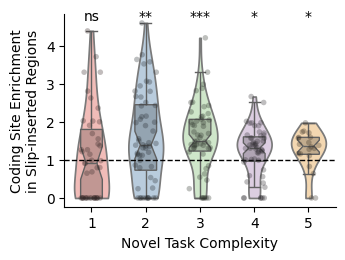

In [24]:
with tp.teed(
    sns.violinplot,
    data=data,
    y="Is Task Coding Site",
    x="Components",
    hue="Components",
    density_norm="width",
    cut=0,
    gap=0.2,
    inner=None,
    legend=False,
    palette="Pastel1",
    teeplot_outexclude="palette",
) as ax:
    sns.boxplot(
        data=data,
        y="Is Task Coding Site",
        x="Components",
        hue="Components",
        gap=0.2,
        notch=True,
        palette=darken_palette("Pastel1", 0.8),
        color="black",
        width=0.5,
        linewidth=1,
        fliersize=0,
        ax=ax,
        legend=False,
    )
    sns.stripplot(
        data=data,
        y="Is Task Coding Site",
        x="Components",
        hue="Components",
        jitter=0.2,
        palette=darken_palette("Pastel1", 0.2),
        size=4,
        alpha=0.3,
        ax=ax,
        legend=False,
    )
    ax.axhline(1, color="black", linestyle="--", lw=1)
    ax.set_ylabel("Coding Site Enrichment\nin Slip-inserted Regions")
    ax.set_xlabel("Novel Task Complexity")
    ax.figure.set_size_inches(3.5, 2.5)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Add significance annotations based on wilcoxon_df
    y_max = ax.get_ylim()[1]
    x_positions = ax.get_xticks()

    # Loop over each component in sorted order
    for i, comp in enumerate(sorted(wilcoxon_df.index)):
        p_val = wilcoxon_df.loc[comp, 'p-value']
        if p_val < 0.001:
            sig = '***'
        elif p_val < 0.01:
            sig = '**'
        elif p_val < 0.05:
            sig = '*'
        else:
            sig = 'ns'
        ax.text(x_positions[i], y_max * 0.95, sig, ha='center', va='bottom', fontsize=10, color='black')


## `viability=exclude`


In [25]:
dfpx = dff[
    ~dff["Prev Is Viability Site"]
].astype(
    {"Prev Slip Insertion Cumulative Count": bool},
).groupby(
    ["Treatment", "Run ID", "Task", "Prev Slip Insertion Cumulative Count"],
    observed=True,
).agg(
    {
        "Mean Is Task Coding Site": "first",
        "Is Task Coding Site": "mean",
        "Components": "first",
        "SLIP_INSERTION_BOOL_MASK any": "first",
    },
)

dfpx["Is Task Coding Site"] /= dfpx["Mean Is Task Coding Site"]
dfpx = dfpx.reset_index()
print(dfpx)

dfpx_ = dfpx.copy()
dfpx_["Prev Slip Insertion Cumulative Count"] = dfpx_[
    "Prev Slip Insertion Cumulative Count"
].map(
    {True: "Slip Inserted", False: "Not Slip Inserted"}
)

data = dfpx_[
    (dfpx_["Prev Slip Insertion Cumulative Count"] == "Slip Inserted")
].groupby(
    ["Prev Slip Insertion Cumulative Count", "Run ID", "Is Task Coding Site", "Components"],
    observed=True,
).median(numeric_only=True).reset_index()


          Treatment    Run ID    Task  Prev Slip Insertion Cumulative Count  \
0    Slip-duplicate  run_1590     AND                                 False   
1    Slip-duplicate  run_1590     AND                                  True   
2    Slip-duplicate  run_1590  ANDNOT                                 False   
3    Slip-duplicate  run_1590  ANDNOT                                  True   
4    Slip-duplicate  run_1590  EQUALS                                 False   
..              ...       ...     ...                                   ...   
479  Slip-duplicate  run_1619      OR                                  True   
480  Slip-duplicate  run_1619   ORNOT                                 False   
481  Slip-duplicate  run_1619   ORNOT                                  True   
482  Slip-duplicate  run_1619     XOR                                 False   
483  Slip-duplicate  run_1619     XOR                                  True   

     Mean Is Task Coding Site  Is Task Coding Site 

In [26]:
# Perform one-sample Wilcoxon signed-rank test for each "Components" group
# against the null hypothesis median = 1.0
wilcoxon_results = data.groupby("Components").apply(
    lambda x: scipy.stats.wilcoxon(
        x["Is Task Coding Site"] - 1.0,  # shift by 1.0
        alternative='greater',
    )
)

# Create a DataFrame to store the test results
wilcoxon_df = pd.DataFrame(
    wilcoxon_results.tolist(),
    index=wilcoxon_results.index,
    columns=["W-statistic", "p-value"]
)

display(wilcoxon_df)

group_stats = data.groupby(["Components", "Prev Slip Insertion Cumulative Count"])["Is Task Coding Site"].agg(["mean", "std"]).reset_index()
display(group_stats)

group_sizes = data.groupby(["Components", "Prev Slip Insertion Cumulative Count"]).size().reset_index(name='size')
display(group_sizes)


/tmp/ipykernel_4025/1046056488.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wilcoxon_results = data.groupby("Components").apply(


,W-statistic,p-value
Components,,
1,475.5,0.381286
2,1114.0,0.000686
3,1243.0,0.000037
4,896.0,0.014465
5,142.0,0.083518


,Components,Prev Slip Insertion Cumulative Count,mean,std
0,1,Slip Inserted,1.149741,1.178198
1,2,Slip Inserted,1.621013,1.183828
2,3,Slip Inserted,1.578724,0.900055
3,4,Slip Inserted,1.220047,0.654747
4,5,Slip Inserted,1.176742,0.596213


,Components,Prev Slip Insertion Cumulative Count,size
0,1,Slip Inserted,42
1,2,Slip Inserted,55
2,3,Slip Inserted,55
3,4,Slip Inserted,51
4,5,Slip Inserted,20


teeplots/density-norm=width+hue=components+viability=exclude+viz=violinplot+x=components+y=is-task-coding-site+ext=.pdf


/tmp/ipykernel_4025/955429831.py:16: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_4025/955429831.py:31: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  sns.stripplot(


teeplots/density-norm=width+hue=components+viability=exclude+viz=violinplot+x=components+y=is-task-coding-site+ext=.png


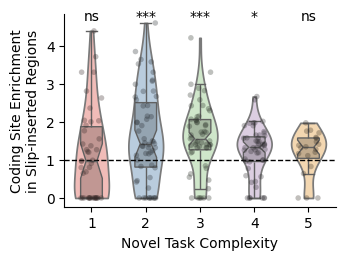

In [27]:
with tp.teed(
    sns.violinplot,
    data=data,
    y="Is Task Coding Site",
    x="Components",
    hue="Components",
    density_norm="width",
    cut=0,
    gap=0.2,
    inner=None,
    legend=False,
    palette="Pastel1",
    teeplot_outattrs={"viability": "exclude"},
    teeplot_outexclude="palette",
) as ax:
    sns.boxplot(
        data=data,
        y="Is Task Coding Site",
        x="Components",
        hue="Components",
        gap=0.2,
        notch=True,
        palette=darken_palette("Pastel1", 0.8),
        color="black",
        width=0.5,
        linewidth=1,
        fliersize=0,
        ax=ax,
        legend=False,
    )
    sns.stripplot(
        data=data,
        y="Is Task Coding Site",
        x="Components",
        hue="Components",
        jitter=0.2,
        palette=darken_palette("Pastel1", 0.2),
        size=4,
        alpha=0.3,
        ax=ax,
        legend=False,
    )
    ax.axhline(1, color="black", linestyle="--", lw=1)
    ax.set_ylabel("Coding Site Enrichment\nin Slip-inserted Regions")
    ax.set_xlabel("Novel Task Complexity")
    ax.figure.set_size_inches(3.5, 2.5)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Add significance annotations based on wilcoxon_df
    y_max = ax.get_ylim()[1]
    x_positions = ax.get_xticks()

    # Loop over each component in sorted order
    for i, comp in enumerate(sorted(wilcoxon_df.index)):
        p_val = wilcoxon_df.loc[comp, 'p-value']
        if p_val < 0.001:
            sig = '***'
        elif p_val < 0.01:
            sig = '**'
        elif p_val < 0.05:
            sig = '*'
        else:
            sig = 'ns'
        ax.text(x_positions[i], y_max * 0.95, sig, ha='center', va='bottom', fontsize=10, color='black')
